# A1
Written by Babak Hosseini Mohtasham 810101408

on 18/12/1402

Using genetic algorithms to find the optimal solution for the knapsack problem.

In [39]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import math

I have used the strategy design pattern to easily change the fitness calculation function. we want the maximum value possible so the fitness is directly proportional to value. We also don't want the weight to exceed the given max weight so the fitness should be inversely proportional to the weight. I have hard coded the third constraint so no need to include it in my fitness functions. I have described 2 different fitness calculating functions:
1. **Fitness value over abs weight strategy**: $fitness = \frac{value-MinSumOfValues}{|weight-MaxSumOfWeights|+0.1}$

2. **Fitness value over square weight strategy**: $fitness = \frac{value-MinSumOfValues}{(weight-MaxSumOfWeights)^{2}+0.1}$

In [40]:
def fitness_value_over_abs_weight_strategy(min_sum_of_values, max_sum_of_weights, value, weight):
    return (value-min_sum_of_values) / (abs(weight-max_sum_of_weights)+0.1)


def fitness_value_over_square_weight_strategy(min_sum_of_values, max_sum_of_weights, value, weight):
    return (value-min_sum_of_values) / (pow(weight-max_sum_of_weights, 2)+0.1)

Similarly I have written two different algorithms for selecting chromosomes for the mating pool:
1. **Ranked selection**: The probability of selection for each chromosome is directly proportional to the number of chromosomes with smaller fitness.

1. **Ranked selection**: The probability of selection for each chromosome is directly proportional to its fitness.

In [41]:
def ranked_selection_strategy(chromosomes):
    n=len(chromosomes)
    fitnesses = np.argsort(np.array([-(chromosome.get_fitness())
                    for chromosome in chromosomes]))[::-1].argsort()
    sum_fitness=n*(n+1)/2
    p = (fitnesses+1)/sum_fitness
    return random.choices(np.arange(n), weights=p, k=n)


def fitness_selection_strategy(chromosomes):
    n = len(chromosomes)
    fitnesses = np.array([-(chromosome.get_fitness()) for chromosome in chromosomes])
    fitnesses += fitnesses.min()+1
    sum_fitness=fitnesses.sum()
    p = (fitnesses)/sum_fitness
    return random.choices(np.arange(n), weights=p, k=n)

def increasing_population_ranked_selection_strategy(chromosomes):
    n = len(chromosomes)
    fitnesses = np.argsort(np.array([-(chromosome.get_fitness())
                                     for chromosome in chromosomes]))[::-1].argsort()
    sum_fitness = n*(n+1)/2
    p = (fitnesses+1)/sum_fitness
    return random.choices(np.arange(n), weights=p, k=n+1)

## Genome
The building element of a chromosome is a genome. Each object of gene has a name equal to one of the snacks in the given CSV file and the corresponding max weight and max value. Furthermore each gene has a specific weight ranging from 0.1 to its max weight. Every genome can randomize its weight for mutation.

In [42]:
class Genome:
    def __init__(self, name, max_weight, max_value) -> None:
        self.name=name
        self.max_weight=max_weight
        self.max_value=max_value
        self.weight=0
        self.randomize_weight()
    def get_value(self):
        return round(self.weight*self.max_value/self.max_weight,3)
    def get_weight(self):
        return self.weight
    def get_name(self):
        return self.name
    def randomize_weight(self):
        self.weight = round(int(random.uniform(0,self.max_weight)*10)/10+0.1,1)
    def copy(self):
        return Genome(self.name,self.max_weight,self.max_value)

## Chromosome
Each chromosome contains some genes and by summing up the weights and values of their genes we get an answer to the knapsack problem. Also with some probability chromosomes can call mutation on their genes.

In [43]:
class Chromosome:
        
    def __init__(self, genese, max_sum_of_weights, min_sum_of_values, min_number_of_genes, max_number_of_genes,fitness_strategy) -> None:
        if isinstance(genese, list):
            self.genes=genese
        elif isinstance(genese, pd.DataFrame):
            number_of_genes=random.randint(min_number_of_genes, max_number_of_genes)
            self.genes = [Genome(row['Snack'],
                                 row['Available Weight'], row['Value']) for _, row in 
                                 genese.sample(n=number_of_genes, replace=False).iterrows()]
        self.min_sum_of_values = min_sum_of_values
        self.max_sum_of_weights = max_sum_of_weights
        self.min_number_of_genes=min_number_of_genes
        self.max_number_of_genes=max_number_of_genes
        self.fitness_strategy = fitness_strategy
    def copy(self):
        return Chromosome(self.genes.copy(), self.max_sum_of_weights, self.min_sum_of_values, 
                          self.min_number_of_genes, self.max_number_of_genes,self.fitness_strategy)
    def get_fitness(self):
        value = self.get_value()
        weight = self.get_weight()
        return self.fitness_strategy(self.min_sum_of_values, self.max_sum_of_weights,value, weight)
    def get_genes(self):
        return (self.genes)
    def set_genes(self,genes):
        new_genes=[gene.copy() for gene in genes]
        self.genes = new_genes
    def mutate(self,p):
        for gene in self.genes:
            rand=random.random()
            if rand>p:
                continue
            gene.randomize_weight()
    def get_weight(self):
        return sum([gene.get_weight() for gene in self.genes])
    def get_value(self):
        return sum([gene.get_value() for gene in self.genes])

## Poulation
Chromosomes form a population together. Before training, the population builds some number of chromosomes then a cycle with 4 steps is repeated for some number of iterations:
1. **Selecting chromosomes**: The population selects some number of chromosomes from the population according to an algorithm. The algorithm gives higher chance of selection to a chromosome with greater fitness.
2. **Crossover**: The selected chromosomes from the previous step get in random pairs and in each pair using an uniform crossover algorithm the genes of the two chromosomes may swap in a way that the third constraint will be met. Now I'm going to prove the lowerbound and upperbound I used for generating a random number used for the number of genes the crossovered chromosome will have such that none of the two chromosomes will have less than MinNumberOfGenes nor more than MaxNumberOfGenes.

$\qquad \textbf{(1)} : MinNumberOfGenes \leqslant A,B \leqslant MaxNumberOfGenes$

$\qquad A = diffA + Common \Rightarrow|A| = |diffA| + |Common|$

$\qquad B = diffB + Common \Rightarrow|B| = |diffB| + |Common|$

$\qquad \textbf{(2)} : NumberOfGenes = |A| + |B| = len(AllGenes)$

$\qquad \textbf{(3)} : \textbf{(2)} \Rightarrow |diffA|+|diffB|+2\times common = NumberOfGenes \Rightarrow diffA = NumberOfGenes - 2\times |Common| - |diffB|\Rightarrow |diffA| =$
$\qquad\qquad NumberOfGenes - |Common| - |B|$

$\qquad \textbf{(4)} : \textbf{(1)} \Rightarrow MinNumberOfGenes - |Common| \leqslant |diffA| \leqslant 4 - |Common|$

$\qquad \textbf{(5)} : \textbf{(1),(3)} \Rightarrow NumberOfGenes - |Common| - MaxNumberOfGenes \leqslant |diffA| \leqslant NumberOfGenes - |Common| - MinNumberOfGenes$

$\qquad \textbf{(4),(5)} \Rightarrow \boxed{max(0,MinNumberOfGenes-|Common|,
                   NumberOfGenes-MaxNumberOfGenes-|Common|) \leqslant |diffA| \leqslant}$
$\qquad\qquad \boxed{min(MaxNumberOfGenes-|Common|,NumberOfGenes-MinNumberOfGeness-|Common_snacks|)}$

3. **Mutate**: In this step the mutation function of each chromosome is called so that some of the genes may get randomized.
4. **Gathering data**: Lastly the necessary information of the population are stored to be included in the report.

After the cycle ends the data gathered from the 4th step of every iteration is stored and then for some number of iterations some chromosomes are build and trained. Finally all the data gathered from all trainings gets plotted so by examining the data we'll be able to decide wether an algorithm works well enough or not.

In [44]:
class Population:
    def __init__(self, file_addr, max_sum_of_weights, min_sum_of_values, min_number_of_genes, max_number_of_genes):
        self.df=pd.read_csv(file_addr)
        self.chromosomes=[]
        self.max_sum_of_weights = max_sum_of_weights
        self.min_sum_of_values = min_sum_of_values
        self.min_number_of_genes = min_number_of_genes
        self.max_number_of_genes = max_number_of_genes
        self.iteration_average=[]
        self.average=[]
        self.best=0
        self.best_chromosomes=[]
        self.best_genes=[]
    def build_chromosomes(self,number_of_chromosomes):
        for _ in range(number_of_chromosomes):
            self.chromosomes.append(Chromosome(
                self.df, self.max_sum_of_weights, self.min_sum_of_values, self.min_number_of_genes, 
                self.max_number_of_genes,self.fitness_strategy))
    def select_chromosomes(self):
        chromosomes=self.chromosomes.copy()
        new_chromosomes = self.select_strategy(chromosomes)
        self.chromosomes = [chromosomes[i].copy() for i in new_chromosomes]
    def crossover(self,p):
        def find_common_snacks(genesA,genesB):
            set_genesA = set()
            set_genesB = set()
            for i, gene in enumerate(genesA):
                set_genesA.add(gene.get_name())
            for i, gene in enumerate(genesB):
                set_genesB.add(gene.get_name())
            return set_genesA.intersection(set_genesB)
        def add_common_snacks():
            for i,gene in enumerate(all_genes):
                name=gene.get_name()
                if name in common_snacks:
                    if name not in seen_genes:
                        new_genesB.append(gene)
                        seen_genes.add(name)
                    else:
                        new_genesA.append(gene)

        def add_different_snacks():
            number_of_genes=len(all_genes)
            rand_a = max(0,self.min_number_of_genes-len(common_snacks),
                         number_of_genes-self.max_number_of_genes-len(common_snacks))
            rand_b = min(self.max_number_of_genes-len(common_snacks),
                         number_of_genes-self.min_number_of_genes-len(common_snacks))
            new_number_of_genesA = random.randint(rand_a, rand_b)
            for i, gene in enumerate(all_genes):
                if gene.get_name() not in common_snacks:
                    if new_number_of_genesA:
                        new_genesA.append(gene)
                        new_number_of_genesA-=1
                    else:
                        new_genesB.append(gene)

        def make_new_chromosomes():
            random.shuffle(all_genes)
            add_common_snacks()
            add_different_snacks()
        
        for chromosomeA, chromosomeB in zip(self.chromosomes[0::2], self.chromosomes[1::2]):
            if random.random()>p:
                continue
            genesA = chromosomeA.get_genes()
            genesB = chromosomeB.get_genes()
            all_genes=(genesA+genesB)
            seen_genes=set()
            common_snacks = find_common_snacks(genesA, genesB)
            new_genesA=[]
            new_genesB=[]
            make_new_chromosomes()
            chromosomeA.set_genes(new_genesA)
            chromosomeB.set_genes(new_genesB)
    def mutate(self,p):
        for chromosome in self.chromosomes:
            chromosome.mutate(p)

    def gather_data(self,i):
        iteration_average = 0
        for chromosome in self.chromosomes:
            iteration_average += chromosome.get_fitness()
            if self.best==0 or chromosome.get_fitness() > (self.best.get_fitness()):
                self.best=chromosome
        self.iteration_average[i]=(iteration_average)

    def train(self, number_of_chromosomes, number_of_iterations_per_run, probability_of_crossover, probability_of_mutation):
        self.build_chromosomes(number_of_chromosomes)
        for i in range(number_of_iterations_per_run):
            self.select_chromosomes()
            self.crossover(probability_of_crossover)
            self.mutate(probability_of_mutation)
            self.gather_data(i)

    def set_config(self, file_addr=None, max_sum_of_weights=None, min_sum_of_values=None, min_number_of_genes=None, max_number_of_genes=None,
                   number_of_chromosomes=None, number_of_iterations_per_run=None, probability_of_crossover=None, probability_of_mutation=None,
                   fitness_strategy=None, select_strategy=None):
        if file_addr is not None:
            self.df = pd.read_csv(file_addr)
        if max_number_of_genes is not None:
            self.max_sum_of_weights = max_sum_of_weights
        if min_sum_of_values is not None:
            self.min_sum_of_values = min_sum_of_values
        if min_number_of_genes is not None:
            self.min_number_of_genes = min_number_of_genes
        if max_number_of_genes is not None:
            self.max_number_of_genes = max_number_of_genes
        if number_of_chromosomes is not None:
            self.number_of_chromosomes = number_of_chromosomes
        if number_of_iterations_per_run is not None:
            self.number_of_iterations_per_run = number_of_iterations_per_run
        if probability_of_crossover is not None:
            self.probability_of_crossover = probability_of_crossover
        if probability_of_mutation is not None:
            self.probability_of_mutation = probability_of_mutation
        if fitness_strategy is not None:
            self.fitness_strategy = fitness_strategy
        if select_strategy is not None:
            self.select_strategy = select_strategy
        
    def run(self, iterations):
        average = np.zeros(
            (iterations, self.number_of_iterations_per_run))
        best_chromosomes = []
        best_genes = []
        self.iteration_average=np.zeros((self.number_of_iterations_per_run))
        for i in range(iterations):
            self.chromosomes.clear()
            self.best=0
            self.train(self.number_of_chromosomes, self.number_of_iterations_per_run,
                       self.probability_of_crossover, self.probability_of_mutation)
            average[i] = (self.iteration_average)/len(self.chromosomes)
            best_chromosomes.append(self.best)
            best_genes.extend(self.best.get_genes())
        self.average = average.mean(axis=0)
        self.best_chromosomes = best_chromosomes
        self.best_genes = best_genes

    def print_best_snacks_cnt(self):
        snacks=[]
        for snack in self.best_genes:
            snacks.append(snack.get_name())
        print("Count of each snack among the best chromosomes:")
        for snack in set(snacks):
            print(f'{snack}: {snacks.count(snack)}')

    def print_best_chromosomes_info(self):
        chromosomes = np.zeros((len(self.best_chromosomes), 3))
        for i,chromosome in enumerate(self.best_chromosomes):
            chromosomes[i] = ([chromosome.get_value(),chromosome.get_weight(),chromosome.get_fitness()])
        print("Best chromosomes in each run:")
        for chromosome in chromosomes:
            print(f'Value: {chromosome[0]}\tWeight: {chromosome[1]}\tFitness: {chromosome[2]}')
        print("Average:")
        print(f'Value: {round(chromosomes.mean(axis=0)[0],3)}\tWeight: {chromosomes.mean(axis=0)[1]}\tFitness: {chromosomes.mean(axis=0)[2]}')

    def plot_averages(self):
        plt.figure(figsize=(6,4))
        plt.title("Average fitness each training in each iteration")
        plt.plot(self.average)
        plt.show()

    def plot_best_snacks_cnt(self):
        snacks=[]
        for snack in self.best_genes:
            snacks.append(snack.get_name())
        plt.figure(figsize=(6,4))
        plt.title("Count of each snack among the best chromosomes")
        plt.hist(snacks)
        plt.show()

### Constants

In [45]:
FILE_ADDR = 'snacks.csv'
MAX_SUM_OF_WEIGHTS=10
MIN_SUM_OF_VALUES=12
MIN_NUMBER_OF_GENES=2
MAX_NUMBER_OF_GENES=4
NUMBER_OF_CHROMOSOMES_IN_A_POPULATION=100
NUMBER_OF_ITERATIONS=1000
PROBABILITY_OF_CROSSOVER=0.9
PROBABILITY_OF_MUTATION=0.01
FITNESS_STRATEGY=fitness_value_over_abs_weight_strategy
SELECTION_STRATEGY=ranked_selection_strategy

In [46]:
population = Population(FILE_ADDR, MAX_SUM_OF_WEIGHTS,
                        MIN_SUM_OF_VALUES, MIN_NUMBER_OF_GENES, MAX_NUMBER_OF_GENES)
population.set_config(number_of_chromosomes=NUMBER_OF_CHROMOSOMES_IN_A_POPULATION,
                      number_of_iterations_per_run=NUMBER_OF_ITERATIONS,
                      probability_of_crossover=PROBABILITY_OF_CROSSOVER, probability_of_mutation=PROBABILITY_OF_MUTATION,
                      fitness_strategy=fitness_value_over_abs_weight_strategy,select_strategy=ranked_selection_strategy)

By trying different combinations of strategies I've decided to use fitness value over abs weight fitness strategy with ranked selection strategy.

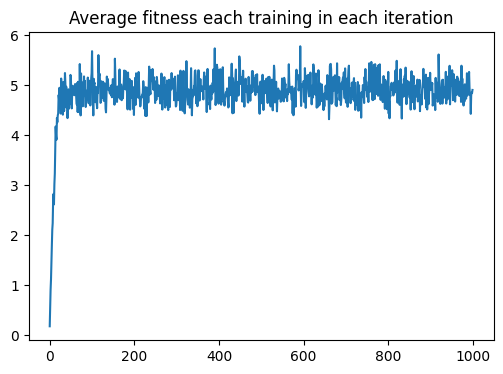

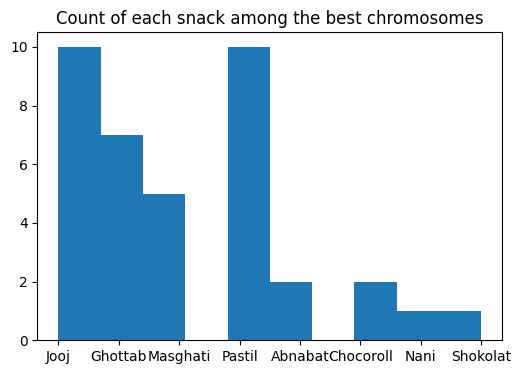

Count of each snack among the best chromosomes:
Nani: 1
Jooj: 10
Chocoroll: 2
Pastil: 10
Abnabat: 2
Masghati: 5
Ghottab: 7
Shokolat: 1
Best chromosomes in each run:
Value: 21.724999999999998	Weight: 10.0	Fitness: 97.24999999999997
Value: 21.09	Weight: 10.0	Fitness: 90.89999999999999
Value: 21.393	Weight: 10.0	Fitness: 93.93
Value: 21.686	Weight: 10.0	Fitness: 96.86
Value: 21.487000000000002	Weight: 10.0	Fitness: 94.87000000000002
Value: 21.634999999999998	Weight: 10.000000000000002	Fitness: 96.34999999999826
Value: 21.224	Weight: 10.0	Fitness: 92.24
Value: 21.814	Weight: 10.0	Fitness: 98.14
Value: 21.82	Weight: 10.0	Fitness: 98.2
Value: 21.707	Weight: 10.0	Fitness: 97.07000000000001
Average:
Value: 21.558	Weight: 10.0	Fitness: 95.58099999999983


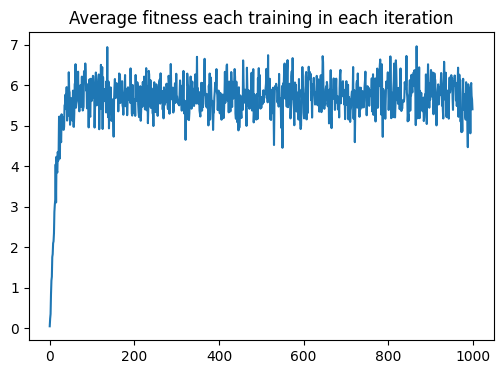

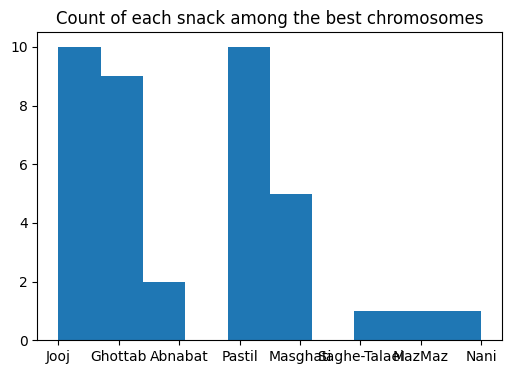

Count of each snack among the best chromosomes:
Nani: 1
Jooj: 10
Saghe-Talaei: 1
Pastil: 10
Abnabat: 2
MazMaz: 1
Masghati: 5
Ghottab: 9
Best chromosomes in each run:
Value: 21.305	Weight: 10.0	Fitness: 93.05
Value: 21.337000000000003	Weight: 10.0	Fitness: 93.37000000000003
Value: 21.511	Weight: 10.0	Fitness: 95.10999999999999
Value: 21.786	Weight: 10.0	Fitness: 97.86000000000001
Value: 21.513	Weight: 10.0	Fitness: 95.13000000000001
Value: 21.447000000000003	Weight: 9.999999999999998	Fitness: 94.47000000000003
Value: 21.018	Weight: 10.0	Fitness: 90.18
Value: 21.643	Weight: 10.0	Fitness: 96.43
Value: 21.552	Weight: 10.0	Fitness: 95.52
Value: 21.433999999999997	Weight: 10.0	Fitness: 94.33999999999997
Average:
Value: 21.455	Weight: 10.0	Fitness: 94.546


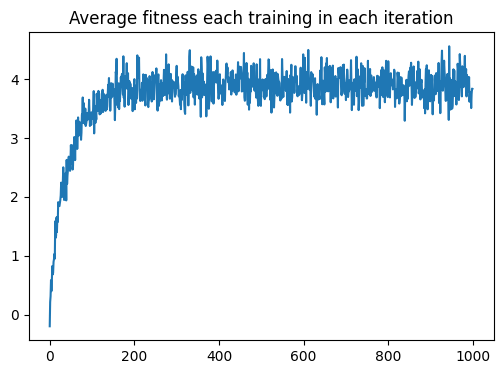

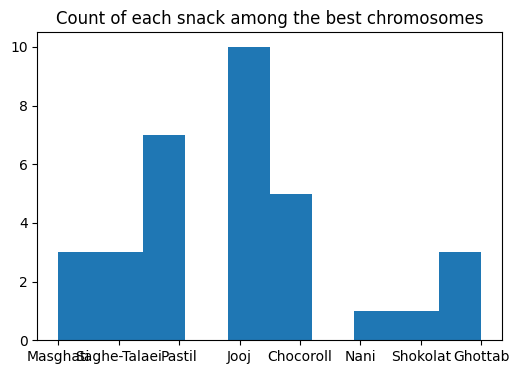

Count of each snack among the best chromosomes:
Nani: 1
Jooj: 10
Saghe-Talaei: 3
Chocoroll: 5
Pastil: 7
Masghati: 3
Shokolat: 1
Ghottab: 3
Best chromosomes in each run:
Value: 21.381	Weight: 10.0	Fitness: 93.81
Value: 21.9	Weight: 10.0	Fitness: 98.99999999999999
Value: 18.73	Weight: 10.0	Fitness: 67.3
Value: 19.016	Weight: 10.0	Fitness: 70.15999999999998
Value: 22.0	Weight: 10.0	Fitness: 100.0
Value: 21.756999999999998	Weight: 10.0	Fitness: 97.56999999999998
Value: 21.919	Weight: 10.0	Fitness: 99.19
Value: 21.064	Weight: 9.999999999999998	Fitness: 90.63999999999838
Value: 19.215	Weight: 10.0	Fitness: 72.14999999999999
Value: 21.206000000000003	Weight: 10.0	Fitness: 92.06000000000003
Average:
Value: 20.819	Weight: 10.0	Fitness: 88.18799999999985


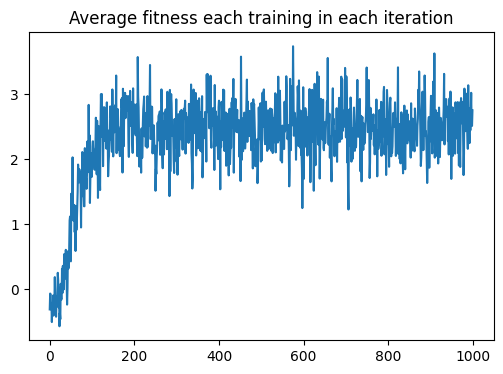

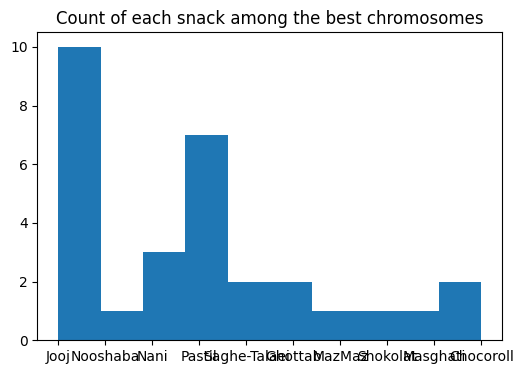

Count of each snack among the best chromosomes:
Nani: 3
Jooj: 10
Chocoroll: 2
Nooshaba: 1
Pastil: 7
MazMaz: 1
Masghati: 1
Saghe-Talaei: 2
Shokolat: 1
Ghottab: 2
Best chromosomes in each run:
Value: 17.753	Weight: 9.9	Fitness: 52.30000000000003
Value: 21.492	Weight: 10.000000000000002	Fitness: 94.92
Value: 21.127000000000002	Weight: 9.999999999999998	Fitness: 91.27000000000002
Value: 18.146	Weight: 10.0	Fitness: 61.46000000000001
Value: 20.514000000000003	Weight: 10.0	Fitness: 85.14000000000003
Value: 20.443	Weight: 9.7	Fitness: 44.43684210526306
Value: 21.314	Weight: 10.0	Fitness: 93.14
Value: 19.142	Weight: 10.0	Fitness: 71.41999999999999
Value: 22.0	Weight: 10.0	Fitness: 100.0
Value: 21.837999999999997	Weight: 10.0	Fitness: 98.37999999999997
Average:
Value: 20.377	Weight: 9.959999999999999	Fitness: 79.24668421052631


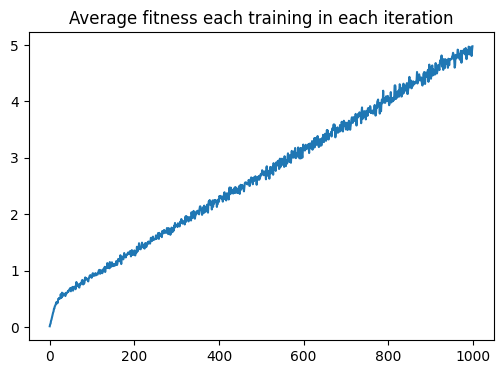

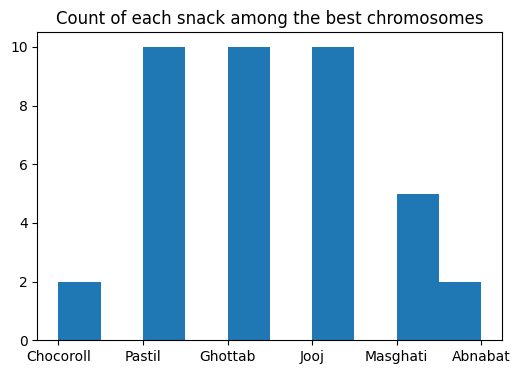

Count of each snack among the best chromosomes:
Jooj: 10
Chocoroll: 2
Pastil: 10
Abnabat: 2
Masghati: 5
Ghottab: 10
Best chromosomes in each run:
Value: 21.829	Weight: 10.0	Fitness: 98.29
Value: 21.506000000000004	Weight: 10.0	Fitness: 95.06000000000003
Value: 21.744	Weight: 10.0	Fitness: 97.44
Value: 21.653	Weight: 10.0	Fitness: 96.52999999999999
Value: 21.653	Weight: 10.0	Fitness: 96.52999999999999
Value: 21.857	Weight: 10.0	Fitness: 98.57
Value: 21.490000000000002	Weight: 10.0	Fitness: 94.90000000000002
Value: 21.669000000000004	Weight: 10.0	Fitness: 96.69000000000004
Value: 21.586000000000002	Weight: 10.0	Fitness: 95.86000000000001
Value: 21.559	Weight: 10.0	Fitness: 95.59
Average:
Value: 21.655	Weight: 10.0	Fitness: 96.546


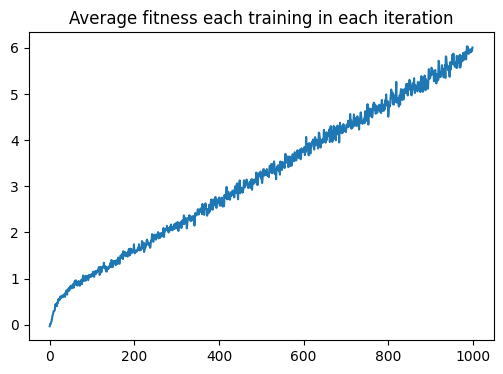

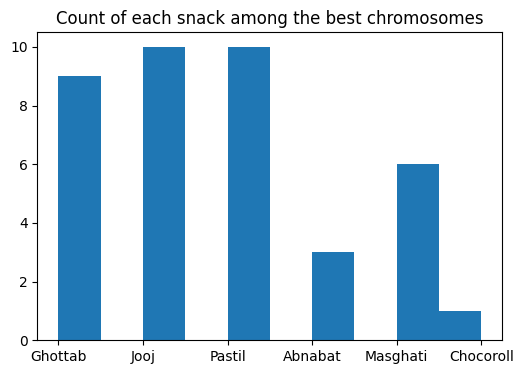

Count of each snack among the best chromosomes:
Jooj: 10
Chocoroll: 1
Pastil: 10
Abnabat: 3
Masghati: 6
Ghottab: 9
Best chromosomes in each run:
Value: 21.629	Weight: 10.0	Fitness: 96.29
Value: 21.653	Weight: 10.0	Fitness: 96.52999999999999
Value: 21.837999999999997	Weight: 10.0	Fitness: 98.37999999999997
Value: 21.834	Weight: 10.0	Fitness: 98.33999999999999
Value: 21.816	Weight: 10.0	Fitness: 98.15999999999998
Value: 21.575000000000003	Weight: 10.0	Fitness: 95.75000000000003
Value: 21.776000000000003	Weight: 9.999999999999998	Fitness: 97.76000000000003
Value: 21.662	Weight: 10.0	Fitness: 96.61999999999999
Value: 21.74	Weight: 10.0	Fitness: 97.39999999999998
Value: 21.74	Weight: 10.0	Fitness: 97.39999999999998
Average:
Value: 21.726	Weight: 10.0	Fitness: 97.26299999999999


In [13]:
population.set_config(fitness_strategy=fitness_value_over_abs_weight_strategy,select_strategy=ranked_selection_strategy)
population.run(10)
population.plot_averages()
population.plot_best_snacks_cnt()
population.print_best_snacks_cnt()
population.print_best_chromosomes_info()
population.set_config(fitness_strategy=fitness_value_over_square_weight_strategy,
                      select_strategy=ranked_selection_strategy)
population.run(10)
population.plot_averages()
population.plot_best_snacks_cnt()
population.print_best_snacks_cnt()
population.print_best_chromosomes_info()
population.set_config(fitness_strategy=fitness_value_over_abs_weight_strategy,
                      select_strategy=fitness_selection_strategy)
population.run(10)
population.plot_averages()
population.plot_best_snacks_cnt()
population.print_best_snacks_cnt()
population.print_best_chromosomes_info()
population.set_config(fitness_strategy=fitness_value_over_square_weight_strategy,
                      select_strategy=fitness_selection_strategy)
population.run(10)
population.plot_averages()
population.plot_best_snacks_cnt()
population.print_best_snacks_cnt()
population.print_best_chromosomes_info()
population.set_config(fitness_strategy=fitness_value_over_abs_weight_strategy,
                      select_strategy=increasing_population_ranked_selection_strategy)
population.run(10)
population.plot_averages()
population.plot_best_snacks_cnt()
population.print_best_snacks_cnt()
population.print_best_chromosomes_info()
population.set_config(fitness_strategy=fitness_value_over_square_weight_strategy,
                      select_strategy=increasing_population_ranked_selection_strategy)
population.run(10)
population.plot_averages()
population.plot_best_snacks_cnt()
population.print_best_snacks_cnt()
population.print_best_chromosomes_info()

In [16]:
population.set_config(fitness_strategy=FITNESS_STRATEGY,
                      select_strategy=SELECTION_STRATEGY)

## Questions

1. By setting the number of initial population so low the simulation runs faster though, the results aren't very optimal and the average fitness doesn't grow with each generation. On the other hand starting with larger population will take much longer to run, though the results are better.

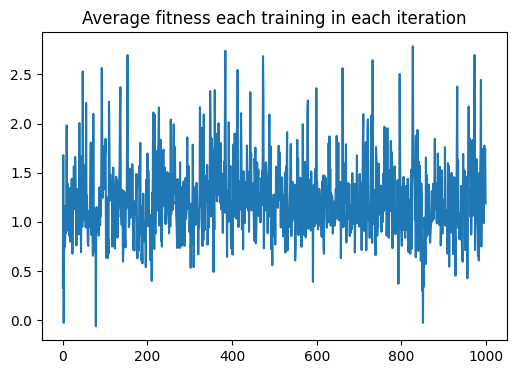

Best chromosomes in each run:
Value: 17.989	Weight: 9.999999999999998	Fitness: 59.88999999999894
Value: 17.25	Weight: 10.0	Fitness: 52.5
Value: 12.684000000000001	Weight: 10.1	Fitness: 3.420000000000011
Value: 16.317	Weight: 9.9	Fitness: 21.58500000000004
Value: 12.924	Weight: 10.1	Fitness: 4.620000000000005
Value: 18.683	Weight: 10.0	Fitness: 66.83
Value: 16.311	Weight: 10.000000000000002	Fitness: 43.10999999999923
Value: 17.343	Weight: 10.0	Fitness: 53.43
Value: 14.644000000000002	Weight: 10.0	Fitness: 26.44000000000002
Value: 16.333	Weight: 10.0	Fitness: 43.329999999999984
Average:
Value: 16.048	Weight: 10.010000000000002	Fitness: 37.51549999999982


In [18]:
population.set_config(number_of_chromosomes=6)
population.run(10)
population.plot_averages()
population.print_best_chromosomes_info()

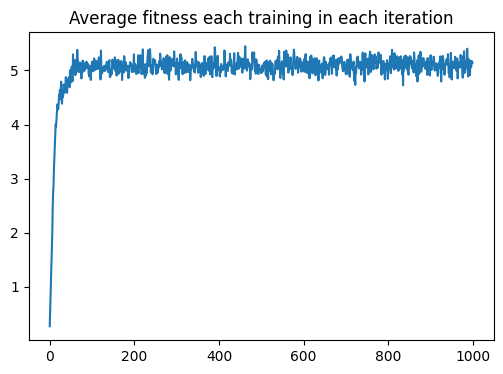

Best chromosomes in each run:
Value: 21.74	Weight: 10.0	Fitness: 97.39999999999998
Value: 21.507	Weight: 10.0	Fitness: 95.07000000000001
Value: 21.834	Weight: 10.0	Fitness: 98.33999999999999
Value: 21.579	Weight: 10.0	Fitness: 95.79
Value: 21.763	Weight: 9.999999999999998	Fitness: 97.62999999999828
Value: 21.679	Weight: 10.0	Fitness: 96.78999999999998
Value: 21.762999999999998	Weight: 10.0	Fitness: 97.62999999999998
Value: 21.743000000000002	Weight: 10.0	Fitness: 97.43000000000002
Value: 21.686000000000003	Weight: 9.999999999999998	Fitness: 96.85999999999831
Value: 21.633000000000003	Weight: 9.999999999999998	Fitness: 96.32999999999831
Average:
Value: 21.693	Weight: 10.0	Fitness: 96.9269999999995


In [19]:
population.set_config(number_of_chromosomes=500)
population.run(10)
population.plot_averages()
population.print_best_chromosomes_info()

2. We can see using this strategy the plot becomes more like an increasing line. At first it doesn't produce well results but as population grows it produces better results though the final results aren't that great with initial population of 2 but if we start with same population in the end the results are usually better than the other selection strategies which makes sense because as population size grows we get better results with the cost of decreasing simulation speed.

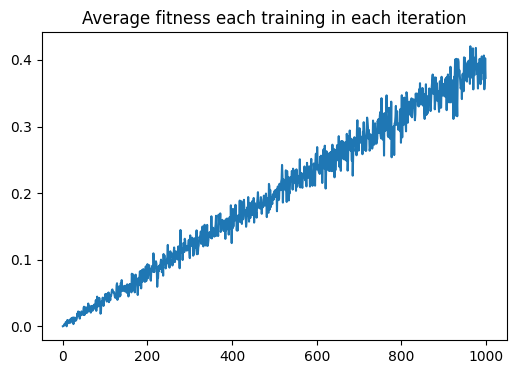

Best chromosomes in each run:
Value: 13.989	Weight: 10.0	Fitness: 19.890000000000008
Value: 12.929	Weight: 10.0	Fitness: 9.290000000000003
Value: 12.852	Weight: 10.0	Fitness: 8.520000000000003
Value: 16.413	Weight: 10.0	Fitness: 44.13
Value: 15.424	Weight: 10.0	Fitness: 34.239999999999995
Value: 32.925	Weight: 40.9	Fitness: 0.6749999999999999
Value: 12.949000000000002	Weight: 10.0	Fitness: 9.490000000000016
Value: 12.812	Weight: 10.0	Fitness: 8.119999999999994
Value: 12.945	Weight: 10.0	Fitness: 9.450000000000003
Value: 13.0	Weight: 10.0	Fitness: 10.0
Average:
Value: 15.624	Weight: 13.09	Fitness: 15.380500000000001


In [20]:
population.set_config(number_of_chromosomes=2,select_strategy=increasing_population_ranked_selection_strategy)
population.run(10)
population.plot_averages()
population.print_best_chromosomes_info()

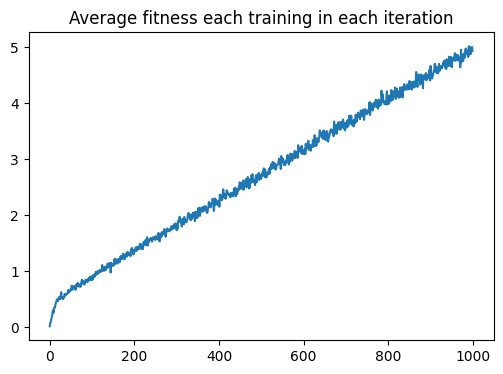

Best chromosomes in each run:
Value: 21.627	Weight: 10.0	Fitness: 96.26999999999998
Value: 21.643	Weight: 10.0	Fitness: 96.43
Value: 21.504	Weight: 10.0	Fitness: 95.04
Value: 21.816	Weight: 10.0	Fitness: 98.15999999999998
Value: 21.919	Weight: 10.0	Fitness: 99.19
Value: 21.673	Weight: 10.0	Fitness: 96.72999999999998
Value: 21.683	Weight: 10.0	Fitness: 96.83
Value: 21.703000000000003	Weight: 9.999999999999998	Fitness: 97.0299999999983
Value: 21.683	Weight: 10.0	Fitness: 96.83
Value: 21.669999999999998	Weight: 10.0	Fitness: 96.69999999999997
Average:
Value: 21.692	Weight: 10.0	Fitness: 96.92099999999982


In [28]:
population.set_config(number_of_chromosomes=NUMBER_OF_CHROMOSOMES_IN_A_POPULATION,select_strategy=increasing_population_ranked_selection_strategy)
population.run(10)
population.plot_averages()
population.print_best_chromosomes_info()

3. If we run the population without crossover we can see that in each run we get a different fitness in some runs the average fitness is better while in some other the average fitness is low. Also the general shape of the plot is very noisys and we can't see any growth in average fitness. The reason for this behavior may be without any crossovers the population may only get better through mutation and selection so if a chromosome has a good gene it wouldn't swap it with other chromosomes to make better chromosomes and after a while the mutation may occurs on that gene so wether a run results in an optimal solution or not depends on the combination of snacks of each chromosome in the initial population and because of that the simulation tends to be random and depend only on good mutations.\
On the other hand, if we don't mutate genes the plot doesn't contain much noise and it is an increasing line. Although the line is non decreasing the results aren't that great. The reason for this behavior may be without any mutation the only way for genes to get better is through crossover and selection but in this way no new gene is created and only the initial genes are swapped to make better chromosomes.\
Not including crossover or mutation in our code decreases the average fitness of the solutions and wether the simulation gets good or bad solutions depends on luck and the initial population, so by having the right rate of crossover and population we can increase the chance of getting better solutions by both swapping our current genes through crossover and creating new genes through mutation. Furthermore having the right probabilities means a good amount of noise and randomness, not too much that would be mostly pure luck and not to low that would only depend on the initial population.

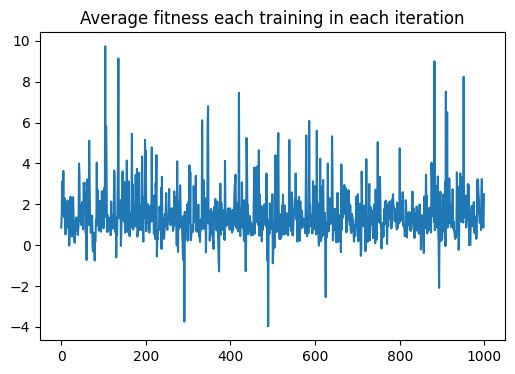

Best chromosomes in each run:
Value: 15.411999999999999	Weight: 15.799999999999999	Fitness: 0.5783050847457627
Value: 24.482	Weight: 20.0	Fitness: 1.2358415841584158
Value: 13.975000000000001	Weight: 11.1	Fitness: 1.6458333333333348
Value: 24.979	Weight: 18.3	Fitness: 1.5451190476190475
Value: 13.049999999999999	Weight: 10.2	Fitness: 3.500000000000005
Value: 15.052999999999999	Weight: 7.300000000000001	Fitness: 1.0903571428571428
Value: 11.181000000000001	Weight: 5.7	Fitness: -0.18613636363636343
Value: 24.516	Weight: 15.7	Fitness: 2.157931034482759
Value: 21.691	Weight: 12.399999999999999	Fitness: 3.8764000000000016
Value: 12.943	Weight: 10.0	Fitness: 9.429999999999996
Average:
Value: 17.728	Weight: 12.65	Fitness: 2.48736508635601


In [29]:
population.set_config(probability_of_crossover=0,select_strategy=SELECTION_STRATEGY,fitness_strategy=FITNESS_STRATEGY)
population.run(10)
population.plot_averages()
population.print_best_chromosomes_info()

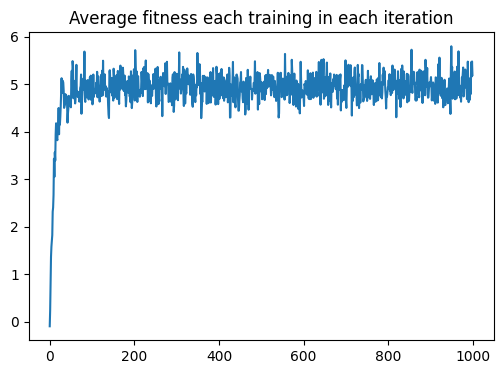

Best chromosomes in each run:
Value: 21.422	Weight: 10.0	Fitness: 94.22
Value: 21.814	Weight: 10.0	Fitness: 98.14
Value: 21.276	Weight: 10.0	Fitness: 92.75999999999999
Value: 21.796	Weight: 9.999999999999998	Fitness: 97.95999999999825
Value: 21.502000000000002	Weight: 10.0	Fitness: 95.02000000000002
Value: 21.084	Weight: 10.0	Fitness: 90.83999999999999
Value: 21.073999999999998	Weight: 10.0	Fitness: 90.73999999999998
Value: 21.578999999999997	Weight: 10.0	Fitness: 95.78999999999996
Value: 21.612	Weight: 10.0	Fitness: 96.11999999999998
Value: 21.416	Weight: 10.0	Fitness: 94.16
Average:
Value: 21.458	Weight: 10.0	Fitness: 94.57499999999982


In [47]:
population.set_config(probability_of_crossover=PROBABILITY_OF_CROSSOVER,probability_of_mutation=0)
population.run(10)
population.plot_averages()
population.print_best_chromosomes_info()

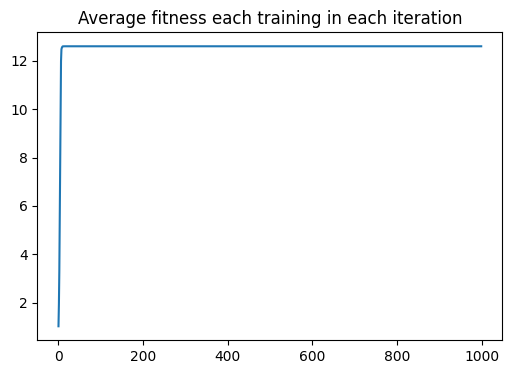

Best chromosomes in each run:
Value: 17.829	Weight: 10.7	Fitness: 7.286250000000008
Value: 18.213	Weight: 12.999999999999998	Fitness: 2.0041935483870983
Value: 14.740000000000002	Weight: 10.000000000000002	Fitness: 27.399999999999533
Value: 15.899999999999999	Weight: 12.1	Fitness: 1.7727272727272723
Value: 16.861	Weight: 10.0	Fitness: 48.61000000000001
Value: 15.835999999999999	Weight: 9.6	Fitness: 7.671999999999992
Value: 18.990000000000002	Weight: 14.3	Fitness: 1.588636363636364
Value: 18.585	Weight: 11.600000000000001	Fitness: 3.873529411764703
Value: 18.443	Weight: 11.1	Fitness: 5.369166666666669
Value: 18.119	Weight: 10.2	Fitness: 20.396666666666714
Average:
Value: 17.352	Weight: 11.259999999999998	Fitness: 12.597316992984839


In [48]:
population.set_config(
    probability_of_crossover=0, probability_of_mutation=0)
population.run(10)
population.plot_averages()
population.print_best_chromosomes_info()

4. By using better fitnesses and algorithms we may be able to find solutions faster. Also one may test different hyperparameters to find the best possible configs to find a soultion as fast as possible. Finally using other machine learning algorithms with higher speed may be another alternative.

5. If we set the mutation low the algorithm may reach a point where the crossover and selection may not be able to make the chromosomes any better and that is when a good mutation can make big changes. The same thing can be said for a low crossover rate. Other than that if we use a bad fitness algorithm the fitness for many solutions may become equal so the algorithm wouldn't be able to make any difference. A good fitness function would include all variables and give different fitnesses for each combination of those variables while giving a higher fitness to combinations closer to the optimal solutions.

6. We can check put a constraint checker in our class to make sure with the givven constraints at least one solution exists though, I assumed the given constraints are logical and a solution exists so if a problem without any solutions is given the genetic algorithm will try to maximize the fitness and after the end of simulation we can see an increasing plot though, the answers are not right.